In [1]:
%pip install numpy seaborn matplotlib pandas pillow tqdm scikit-learn torch torchvision backpack-for-pytorch opt_einsum


[notice] A new release of pip is available: 23.3.1 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

N_up = 2
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
N_up = 1
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import os
import time
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Step #0: Define Experimental Setup

In [4]:
from pathlib import Path

# general
device = "cuda:0"
model_name = "resnet18"
dataset = "MNIST"
# train_batch_size = 512
# laplace_batch_size = 128
# test_batch_size = 256
train_batch_size = 256 #sd_
laplace_batch_size = 64 #sd_
test_batch_size = 64 #sd_

n_test_data = None
rotations = [0, 30, 60, 90, 120, 150, 180]
n_out = 10
loss = "cross_entropy"

# paths
data_dir = "./data"
root_dir = Path(f"./{model_name}_{dataset}")
ggn_dir = root_dir / "ggn.pt"

# subnetwork selection
n_weights_subnet = 10000
subnet_selection = "min-wass" # "magnitude", "min-wass"

# prediction
pred_lambda = 42.

# Step #1: Train or Load Model

In [5]:
from src.scripts.train_classification import train_loop
from src.utils import list_batchnorm_layers, get_n_params, model_to_device, instantiate_model
start_time=time.time()

model = model_to_device(instantiate_model(model_name, dataset, 0.1), device)
bn_layers = list_batchnorm_layers(model)
print('Nparams:', get_n_params(model, bn_layers))

gpu = 0
train_loop(model, dname=dataset, data_dir=data_dir, epochs=20, workers=4, gpu=gpu, resume=str(root_dir / 'model_best.pth.tar'),
            weight_decay=1e-4, save_dir=str(root_dir), milestones=[10, 17], MC_samples=1, batch_size=train_batch_size)

end_time=time.time()
mins_elapsed= round((end_time-start_time)/60, 2)
print(f"{mins_elapsed} mins elapsed...")

Nparams: 11163200
Use GPU: 0 for training
=> loading checkpoint 'resnet18_MNIST/model_best.pth.tar'
=> loaded checkpoint 'resnet18_MNIST/model_best.pth.tar' (epoch 22)
=> found progress file at 'resnet18_MNIST/stats_array.pkl'
=> Loaded progress file at 'resnet18_MNIST/stats_array.pkl'
Ntrain: 60000, Nval: 10000


# Step #2: Select Subnetwork

In [6]:
from src.datasets.image_loaders import get_image_loader
from src.utils import print_nonzeros
from src.masking.masking import random_mask, smallest_magnitude_mask, wasserstein_mask

start_time=time.time()
# compute subnetwork mask
if n_weights_subnet == None:
    mask = None

elif subnet_selection == "random":
    mask, index_mask, weight_score_vec = random_mask(model, bn_layers, n_weights_subnet, device=device)

elif subnet_selection == "min-wass":
    train_loader = get_image_loader(dataset, batch_size=train_batch_size, cuda=True, workers=4, distributed=False, data_dir=data_dir)[1]
    mask, index_mask, weight_score_vec = wasserstein_mask(model, bn_layers, n_weights_subnet, train_loader, device)

elif subnet_selection == "magnitude":
    mask, index_mask, weight_score_vec = smallest_magnitude_mask(model, bn_layers, n_weights_subnet)
    
else:
    raise NotImplementedError("Supported subnetwork selection methods: random, min-wass, magnitude.")

if mask is not None:
    # print mask information
    print_nonzeros(mask)

end_time=time.time()
mins_elapsed= round((end_time-start_time)/60, 2)
print(f"{mins_elapsed} mins elapsed...")

Ntrain: 60000, Nval: 10000


100%|██████████| 256/256 [35:06<00:00,  8.23s/it]


conv1.0.weight                      | remaining =     238 /     576 ( 41.32%) | pruned =     338 | shape = torch.Size([64, 1, 3, 3])
layer_list.0.conv1.weight           | remaining =     615 /   36864 (  1.67%) | pruned =   36249 | shape = torch.Size([64, 64, 3, 3])
layer_list.0.conv2.weight           | remaining =     566 /   36864 (  1.54%) | pruned =   36298 | shape = torch.Size([64, 64, 3, 3])
layer_list.1.conv1.weight           | remaining =     405 /   36864 (  1.10%) | pruned =   36459 | shape = torch.Size([64, 64, 3, 3])
layer_list.1.conv2.weight           | remaining =     394 /   36864 (  1.07%) | pruned =   36470 | shape = torch.Size([64, 64, 3, 3])
layer_list.2.conv1.weight           | remaining =      46 /   73728 (  0.06%) | pruned =   73682 | shape = torch.Size([128, 64, 3, 3])
layer_list.2.conv2.weight           | remaining =      64 /  147456 (  0.04%) | pruned =  147392 | shape = torch.Size([128, 128, 3, 3])
layer_list.2.downsample.0.weight    | remaining =    1901 / 

# Step #3: Do Linearized Laplace Inference

In [7]:
from src.laplace.laplace import Laplace
from src.datasets.image_loaders import get_image_loader

start_time=time.time()
# instantiate Laplace model
laplace_dir = root_dir / f"laplace.pth.tar"
laplace_model = Laplace(model, mask=mask, index_mask=index_mask, save_path=laplace_dir, device=device, loss=loss, n_out=n_out)

# load or fit Hessian approximation
if ggn_dir.exists():
    print("Loading GGN from disk...")
    laplace_model.H = torch.load(ggn_dir)

elif laplace_dir.exists():
    print("Loading Laplace model from disk...")
    laplace_model.load()

else:
    print(f"Computing Hessian/GGN...")
    train_loader = get_image_loader(dataset, batch_size=laplace_batch_size, cuda=True, workers=2, distributed=False, data_dir=data_dir)[1]
    laplace_model.fit_laplace(train_loader)

end_time=time.time()
mins_elapsed= round((end_time-start_time)/60, 2)
print(f"{mins_elapsed} mins elapsed...")

Loading Laplace model from disk...


# Step #4: Make Predictions

In [8]:
import numpy as np

results_path = root_dir / "results.npy"
if results_path.exists():
    results_dict = np.load(results_path, allow_pickle=True).item()
else:
    results_dict = {}

In [11]:
import numpy as np

from src.evaluation.evaluate_laplace import evaluate_laplace
from src.evaluation.evaluate_baselines import evaluate_map

methods = ["MAP", "subnetwork_inference"]
start_time=time.time()

# compute error, log-likelihood, Brier score and ECE on shifted test data
for method in methods:
    for rot in rotations:
        if method in results_dict and rot in results_dict[method]:
            continue
        elif method not in results_dict:
            results_dict[method] = {}

        print(f"Computing predictions for {method} at rotation={rot}...")
        
        if method == "MAP":
            results_dict[method][rot] = evaluate_map(model, dataset, data_dir, device, loss, corruption=None,
                                                    rotation=rot, batch_size=test_batch_size, n_test_data=n_test_data)
        else:
            results_dict[method][rot] = evaluate_laplace(laplace_model, dataset, data_dir, corruption=None, rotation=rot, 
                                                        batch_size=test_batch_size, λ=pred_lambda, n_test_data=n_test_data)

# save result dictionary
np.save(results_path, results_dict)

end_time=time.time()
mins_elapsed= round((end_time-start_time)/60, 2)
print(f"{mins_elapsed} mins elapsed...")

Computing predictions for subnetwork_inference at rotation=60...
Computing covariance matrix...


  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'src.models.img_resnets.ResNet'> although the module has parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'src.models.img_resnets.BasicBlock'> although the module has parameters
  warnings.warn(


Computing predictions for subnetwork_inference at rotation=90...
Computing covariance matrix...


/workspace/subnetwork_inference/src/evaluation/utils.py:61: RuntimeWarning: Mean of empty slice.
  reference = np.array([expanded_preds[bin_idxs == nbin].mean() for nbin in range(n_bins)])
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/157 [00:00<?, ?it/s]

Computing predictions for subnetwork_inference at rotation=120...
Computing covariance matrix...


  0%|          | 0/157 [00:00<?, ?it/s]

Computing predictions for subnetwork_inference at rotation=150...
Computing covariance matrix...


  0%|          | 0/157 [00:00<?, ?it/s]

Computing predictions for subnetwork_inference at rotation=180...
Computing covariance matrix...


  0%|          | 0/157 [00:00<?, ?it/s]

# Step #5: Plot Results

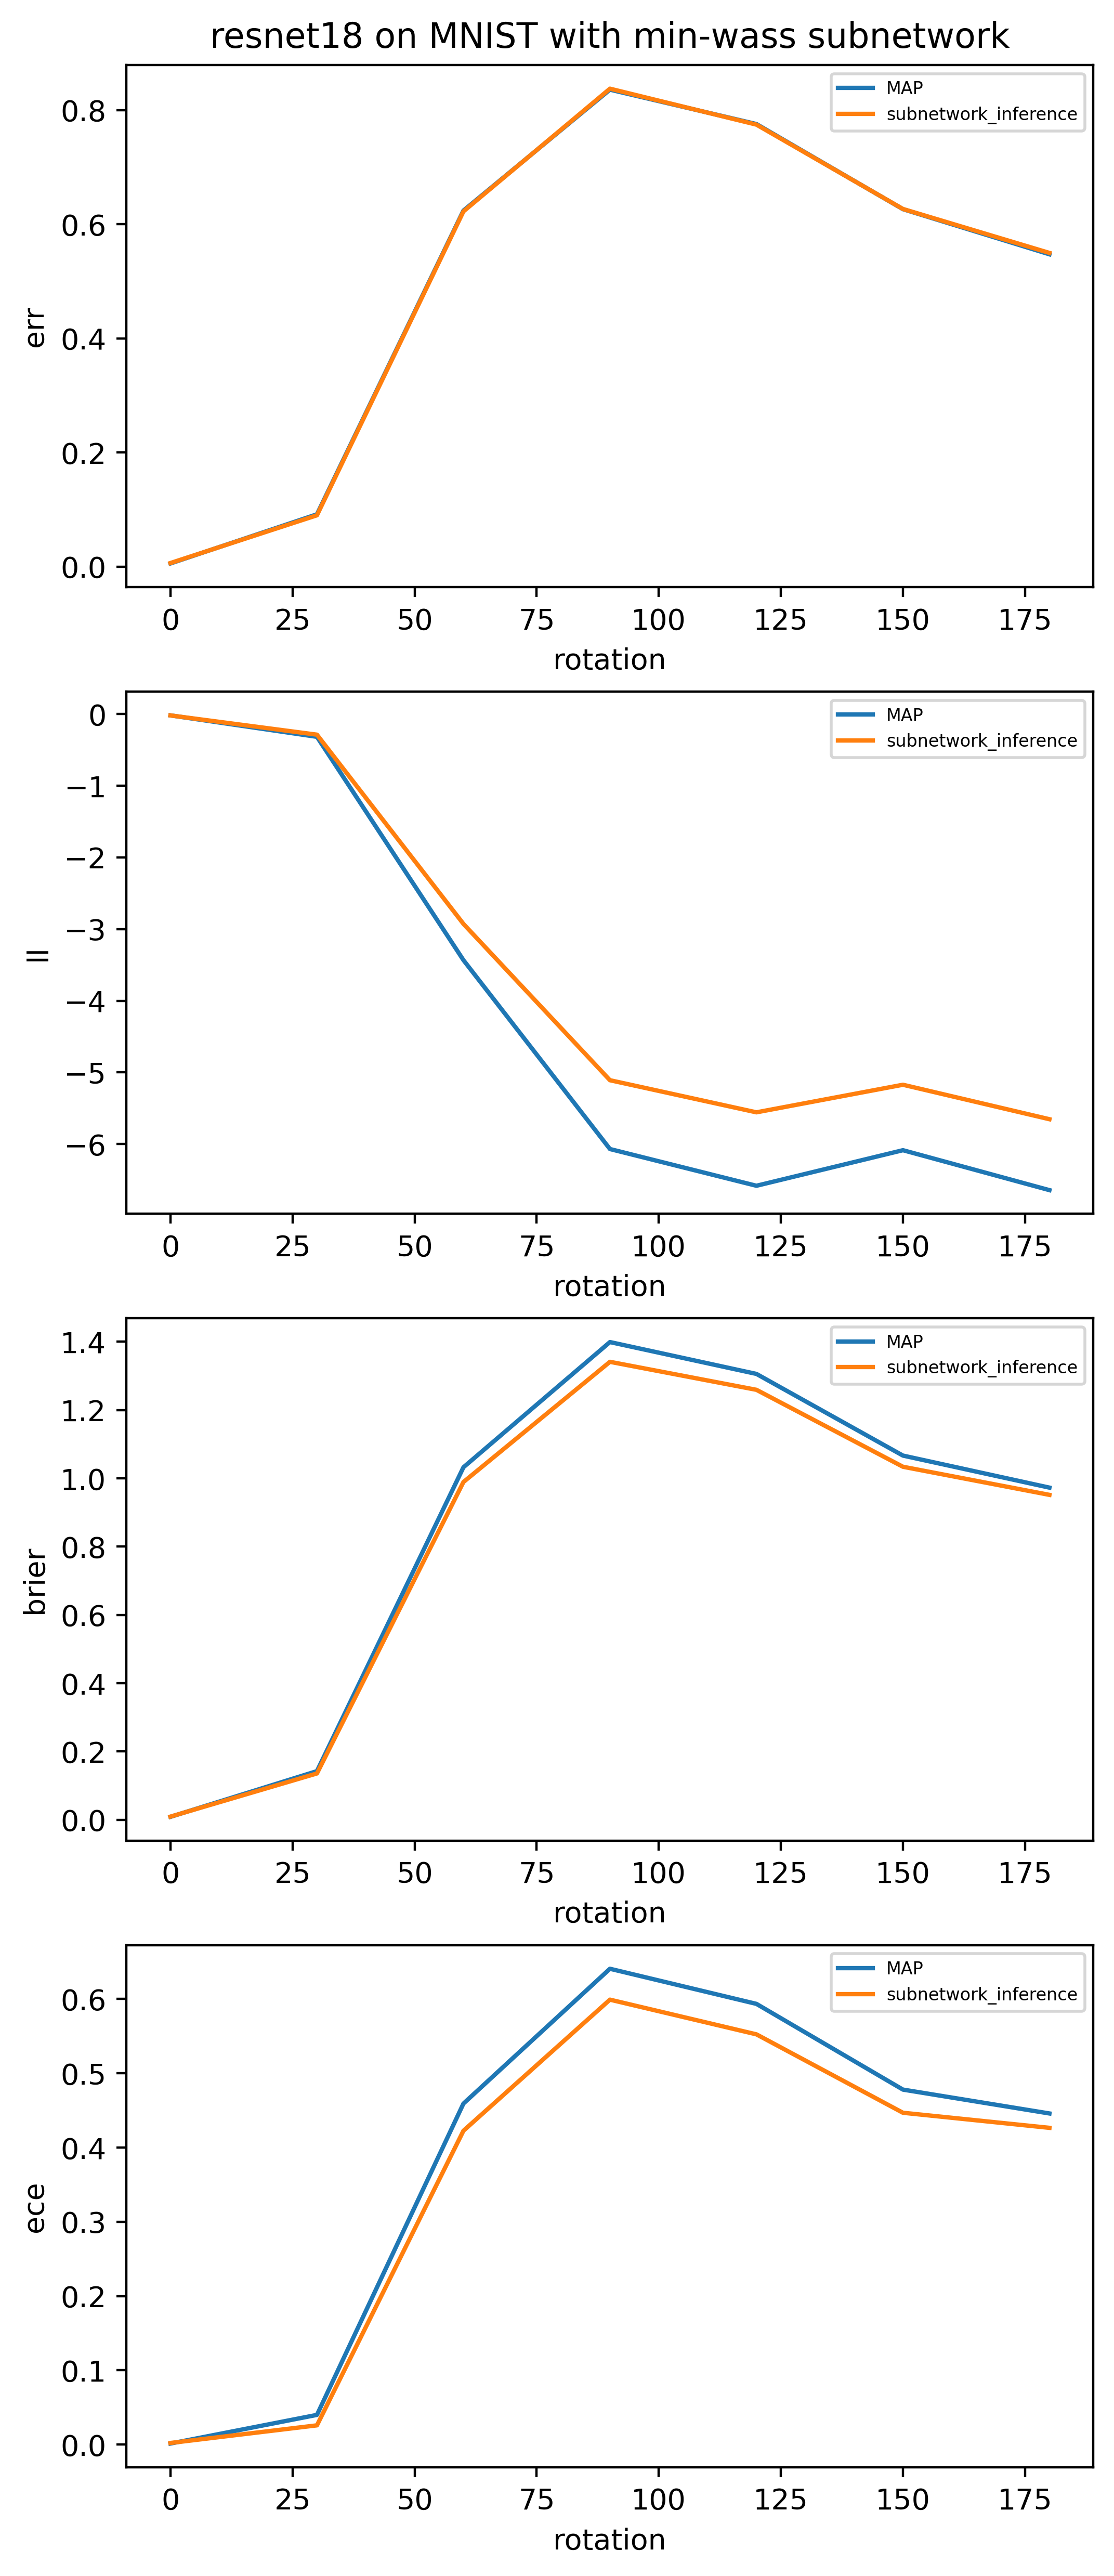

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# methods_to_plot = ["MAP", "subnetwork_inference"]

# metrics = results_dict[methods_to_plot[0]][rotations[0]].keys()

# fig, axes = plt.subplots(4, 1, figsize = (6, 15), dpi=400)
# axes[0].set_title(f"{model_name} on {dataset} with {subnet_selection} subnetwork")

# xs = list(results_dict[methods_to_plot[0]].keys())
# for metric, axis in zip(metrics, axes):
#     for method in methods_to_plot:
#         ys = [results_dict[method][rot][metric] for rot in results_dict[method]]
#         axis.plot(xs, ys, label=method)
#     axis.set_ylabel(metric)
#     axis.set_xlabel("rotation")
#     axis.legend(prop={'size': 6})

# plt.show()

In [17]:
results_dict

{'MAP': {0: {'err': 0.0055,
   'll': -0.017918722704052925,
   'brier': 0.008828118443489075,
   'ece': 0.0012974535495240932},
  30: {'err': 0.0916,
   'll': -0.31724056601524353,
   'brier': 0.1426483690738678,
   'ece': 0.03986351446215354},
  60: {'err': 0.6238,
   'll': -3.433685064315796,
   'brier': 1.0325517654418945,
   'ece': 0.4591777939439057},
  90: {'err': 0.8357,
   'll': -6.069594383239746,
   'brier': 1.3992431163787842,
   'ece': 0.6407408374071222},
  120: {'err': 0.7754,
   'll': -6.582309246063232,
   'brier': 1.3059641122817993,
   'ece': 0.5934311488777522},
  150: {'err': 0.6263,
   'll': -6.08603572845459,
   'brier': 1.0667928457260132,
   'ece': 0.47798143978716734},
  180: {'err': 0.5472,
   'll': -6.643350601196289,
   'brier': 0.9729404449462891,
   'ece': 0.44584181360902453}},
 'subnetwork_inference': {0: {'err': 0.0062,
   'll': -0.018696296960115433,
   'brier': 0.009395898319780827,
   'ece': 0.0020308069020304464},
  30: {'err': 0.0899,
   'll': -0.2

In [15]:
# res_dict={'MAP': {0: {'err': 0.0055,
#    'll': -0.017918722704052925,
#    'brier': 0.008828118443489075,
#    'ece': 0.0012974535495240932},
#   30: {'err': 0.0916,
#    'll': -0.31724056601524353,
#    'brier': 0.1426483690738678,
#    'ece': 0.03986351446215354},
#   60: {'err': 0.6238,
#    'll': -3.433685064315796,
#    'brier': 1.0325517654418945,
#    'ece': 0.4591777939439057},
#   90: {'err': 0.8357,
#    'll': -6.069594383239746,
#    'brier': 1.3992431163787842,
#    'ece': 0.6407408374071222},
#   120: {'err': 0.7754,
#    'll': -6.582309246063232,
#    'brier': 1.3059641122817993,
#    'ece': 0.5934311488777522},
#   150: {'err': 0.6263,
#    'll': -6.08603572845459,
#    'brier': 1.0667928457260132,
#    'ece': 0.47798143978716734},
#   180: {'err': 0.5472,
#    'll': -6.643350601196289,
#    'brier': 0.9729404449462891,
#    'ece': 0.44584181360902453}},
#  'subnetwork_inference': {0: {'err': 0.0062,
#    'll': -0.018696296960115433,
#    'brier': 0.009395898319780827,
#    'ece': 0.0020308069020304464},
#   30: {'err': 0.0899,
#    'll': -0.2872846722602844,
#    'brier': 0.13589704036712646,
#    'ece': 0.025795292919906638},
#   60: {'err': 0.6224,
#    'll': -2.92803955078125,
#    'brier': 0.9893866181373596,
#    'ece': 0.42258202916386034},
#   90: {'err': 0.8374,
#    'll': -5.109302043914795,
#    'brier': 1.3413947820663452,
#    'ece': 0.5991244726210936},
#   120: {'err': 0.7744,
#    'll': -5.55750846862793,
#    'brier': 1.2594013214111328,
#    'ece': 0.5523982672631875},
#   150: {'err': 0.6266,
#    'll': -5.172565460205078,
#    'brier': 1.0340783596038818,
#    'ece': 0.44679273195268554},
#   180: {'err': 0.5496,
#    'll': -5.653649806976318,
#    'brier': 0.9517439603805542,
#    'ece': 0.42649198775591435}}}

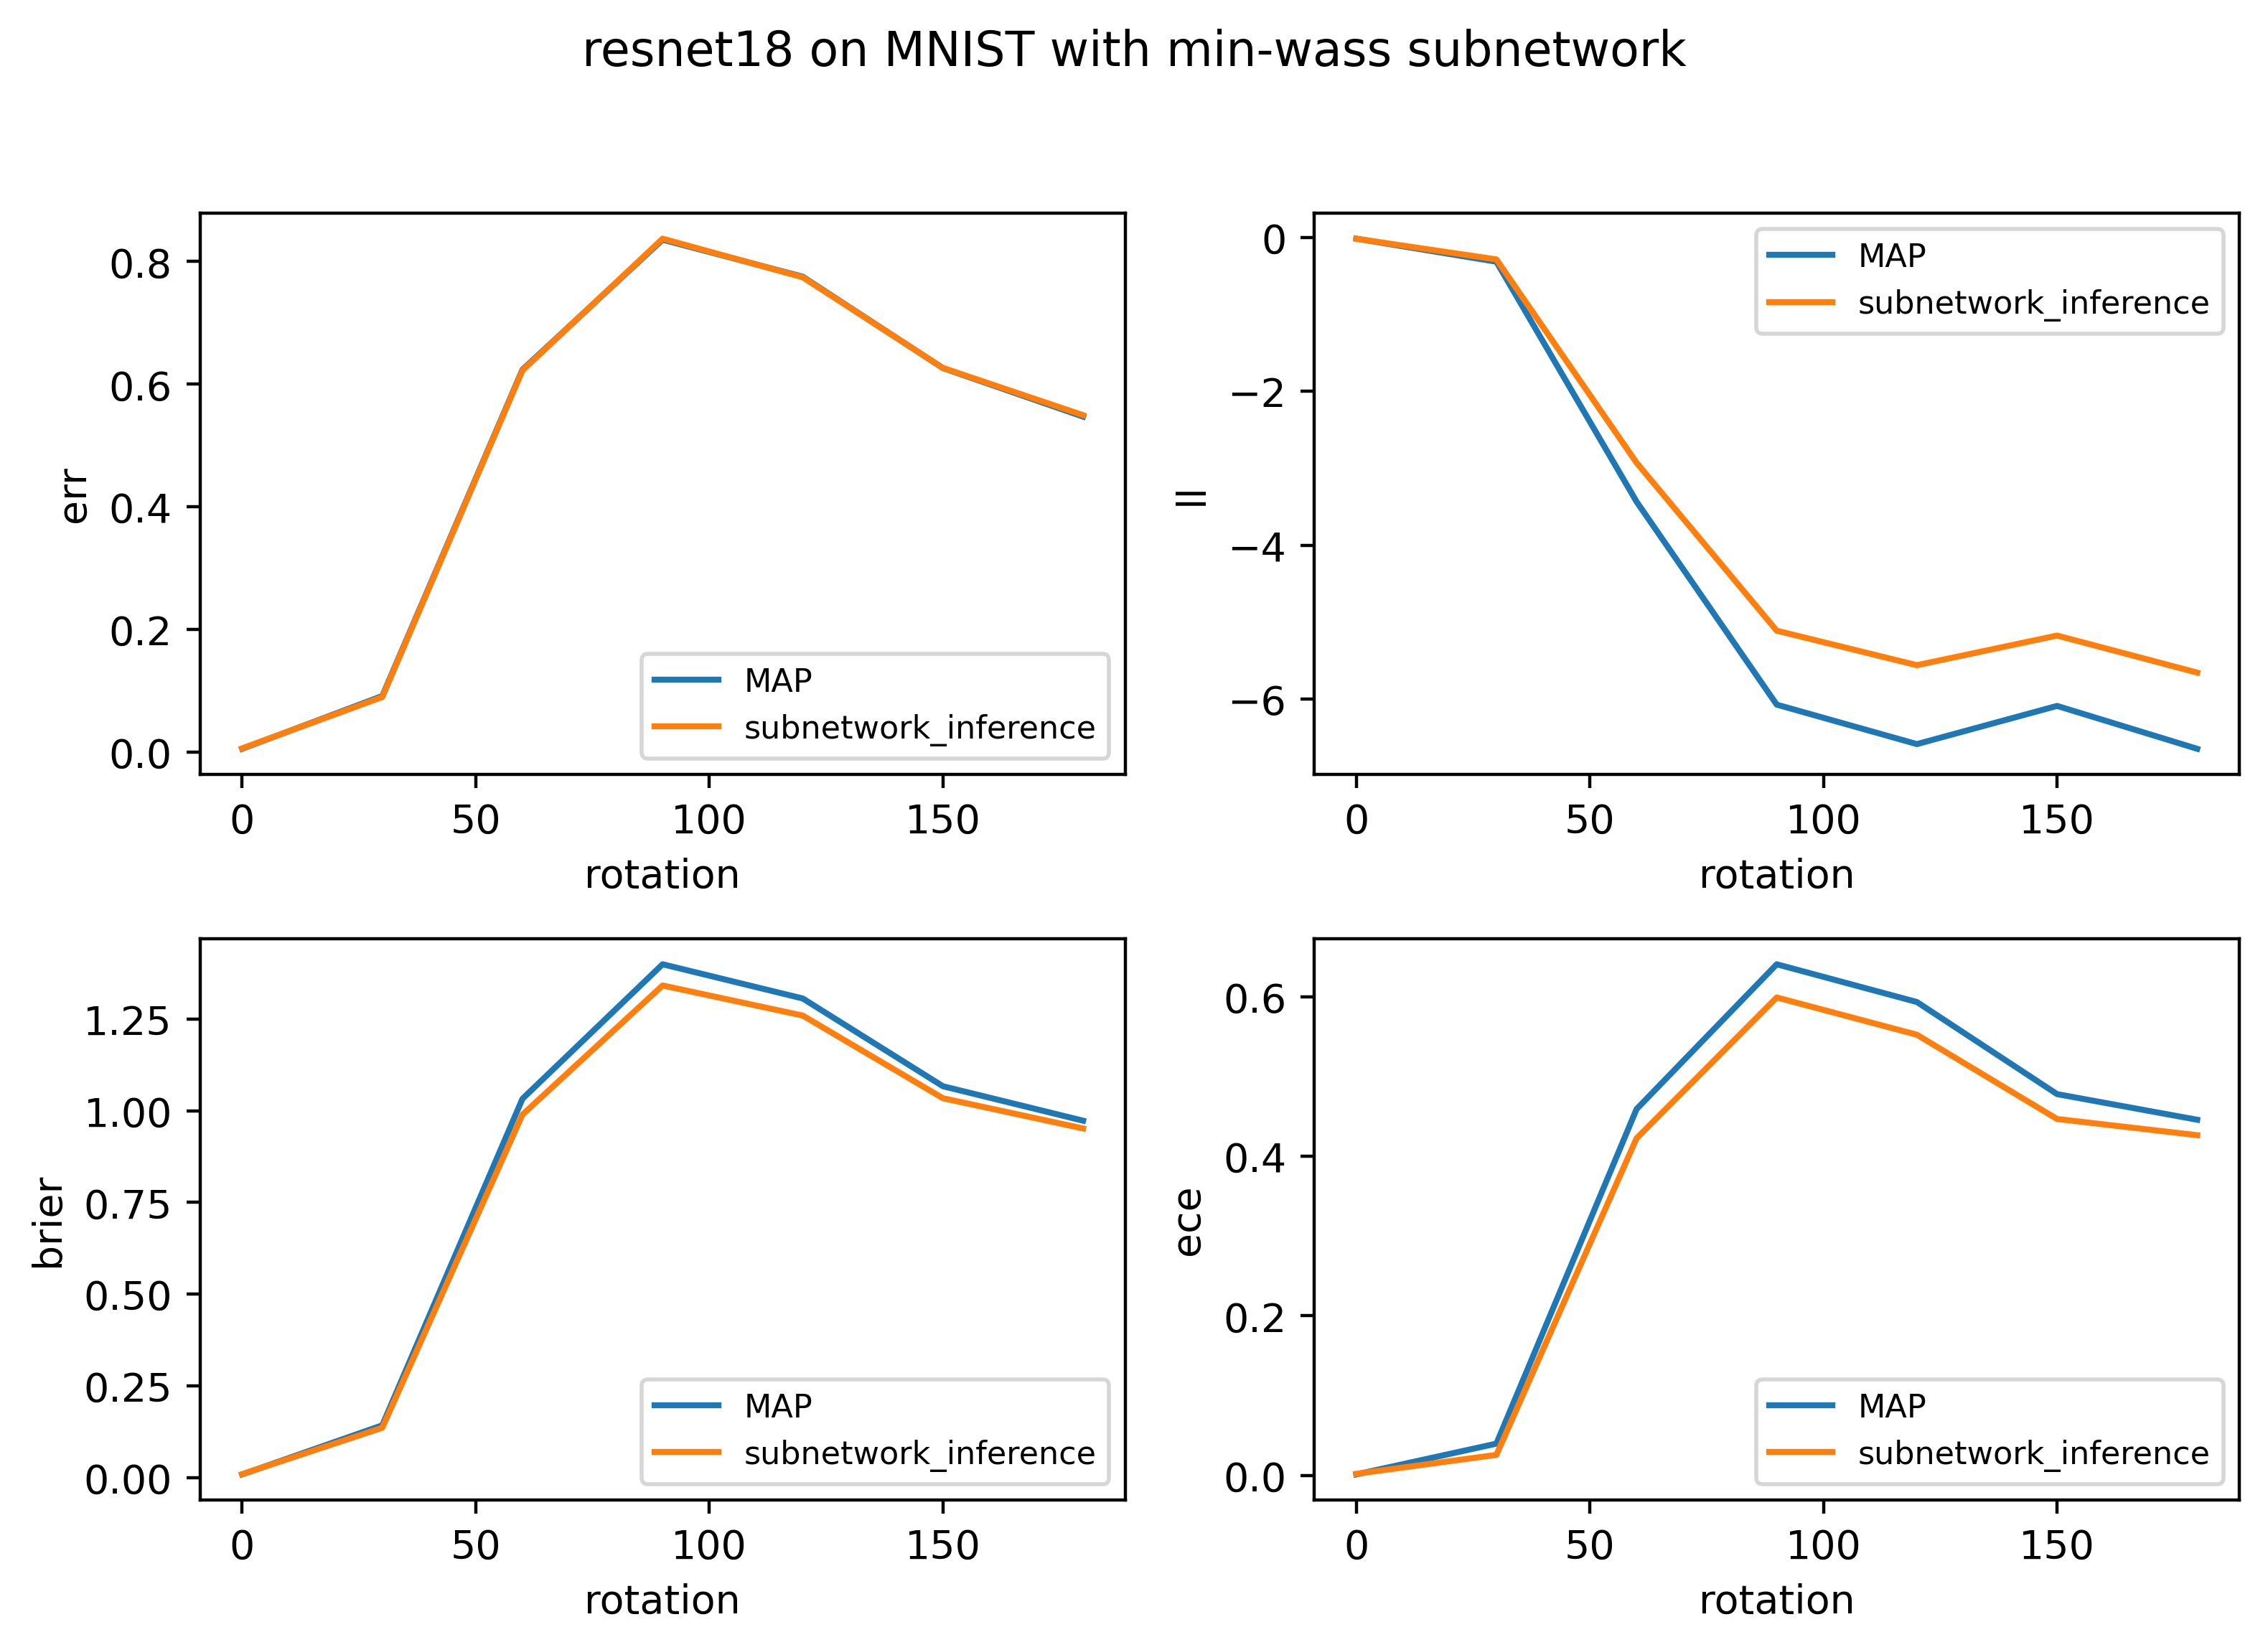

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

start_time=time.time()

methods_to_plot = ["MAP", "subnetwork_inference"]
# results_dict = res_dict.copy()

if 'model_name' not in locals():
    model_name = "ResNet18"
if 'dataset' not in locals():
    dataset = "CIFAR10"
if 'subnet_selection' not in locals():
    subnet_selection = "random"
if 'rotations' not in locals():
    rotations = list(results_dict[methods_to_plot[0]].keys())

metrics = list(results_dict[methods_to_plot[0]][rotations[0]].keys())

fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=400)
fig.suptitle(f"{model_name} on {dataset} with {subnet_selection} subnetwork")
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

xs = list(results_dict[methods_to_plot[0]].keys())
for i, metric in enumerate(metrics):
    ax = axes[i]
    for method in methods_to_plot:
        ys = [results_dict[method][rot][metric] for rot in results_dict[method]]
        ax.plot(xs, ys, label=method)
    ax.set_ylabel(metric)
    ax.set_xlabel("rotation")
    ax.legend(prop={'size': 8})

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap and make space for suptitle
plt.show()

end_time=time.time()
mins_elapsed= round((end_time-start_time)/60, 2)
print(f"{mins_elapsed} mins elapsed...")

### comment:
- for the 1st plot has very close err for both subnetwork and MAP... that's why only 1 color is showing.

In [27]:
# Create a list to hold the rows of the DataFrame
rows_list = []

# Iterate through the outer dictionary (methods)
for method, rotations_data in results_dict.items():
    # Iterate through the inner dictionary (rotations)
    for rotation, metrics in rotations_data.items():
        # Create a dictionary for each row
        row_dict = {'method': method, 'rotation': rotation}
        row_dict.update(metrics)  # Add 'err', 'll', 'brier', 'ece'
        rows_list.append(row_dict)

# Create the DataFrame from the list of dictionaries
df = pd.DataFrame(rows_list)

display(df)

,method,rotation,err,ll,brier,ece
0,MAP,0,0.0055,-0.017919,0.008828,0.001297
1,MAP,30,0.0916,-0.317241,0.142648,0.039864
2,MAP,60,0.6238,-3.433685,1.032552,0.459178
3,MAP,90,0.8357,-6.069594,1.399243,0.640741
4,MAP,120,0.7754,-6.582309,1.305964,0.593431
5,MAP,150,0.6263,-6.086036,1.066793,0.477981
6,MAP,180,0.5472,-6.643351,0.972940,0.445842
7,subnetwork_inference,0,0.0062,-0.018696,0.009396,0.002031
8,subnetwork_inference,30,0.0899,-0.287285,0.135897,0.025795
9,subnetwork_inference,60,0.6224,-2.928040,0.989387,0.422582


In [31]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"Results_{timestamp}.csv"
df.to_csv('Results_.csv') # always overwrites this one, contains latest
df.to_csv(filename, index=False) # keeps track of all files
print(f"Results saved as: {filename}") 

Results saved as: Results_20250501_145948.csv


### Updates:
- changed to smaller batch_sizes for train, laplace and test (to run faster)
- added time tracker.
- alternative plot.